In [13]:
import matplotlib.pyplot as plt
from bokeh.plotting import output_notebook, figure, show
import statistics

START_TIME = 1.0 # in seconds
BW = 100 # in Gbps
PORT_NO_START = 1000

In [5]:
def read_flow_stats(flow_stats_filename):

  flow_stats = {}
  with open(flow_stats_filename, 'r') as f:
    for line in f:
      flow_stat_log = line.split()

      time = float(flow_stat_log[0])*1e-9 - START_TIME # in seconds
      sender = flow_stat_log[1]
      cwnd = float(flow_stat_log[4]) * 1e-3 # in KB
      rtt = float(flow_stat_log[5]) * 1e-3 # in usec

      if (rtt != 0):
        rate = cwnd * 8.0 / rtt # in Gbps
      elif (cwnd != 0):
        rate = BW

      if sender in flow_stats.keys():
        flow_stats[sender]['times'].append(time)
        flow_stats[sender]['rates'].append(rate)
        flow_stats[sender]['cwnds'].append(cwnd)
        flow_stats[sender]['rtts'].append(rtt)
      else:
        flow_stats[sender] = {}
        flow_stats[sender]['times'] = [time]
        flow_stats[sender]['rates'] = [rate]
        flow_stats[sender]['cwnds'] = [cwnd]
        flow_stats[sender]['rtts'] = [rtt]

  return flow_stats

In [6]:
def read_queue_log(filename):
  retval = {}
  retval['times'] = []
  retval['q_sizes'] = []
  with open(filename, 'r') as f:
    for line in f:
      queue_log = line.split()
      try:
        time = float(queue_log[0])*1e-9 - START_TIME # in seconds
        q_size = float(queue_log[1]) * 8.0 / BW * 1e-3 # in usec
      except:
        continue

      retval['times'].append(time)
      retval['q_sizes'].append(q_size)

  return retval

# SWIFT - Effect of Control Action to Convergence at New Flow Arrival

In [7]:
ais = [1, 2, 4, 8, 16] # additive increase factor
flow_stats_data = {}
qlog_data = {}
folder_path = 'outputs/bolt-bts-benchmarks/'
for ai in ais:
  filename = folder_path + 'ai' + str(ai) + '_0_MSGAGG_SWIFT_PERHOP'
  flow_stats_filename = filename + '.log'
  qlog_filename = filename + '.qlen'
  flow_stats_data[str(ai)] = read_flow_stats(flow_stats_filename)
  qlog_data[str(ai)] = read_queue_log(qlog_filename)

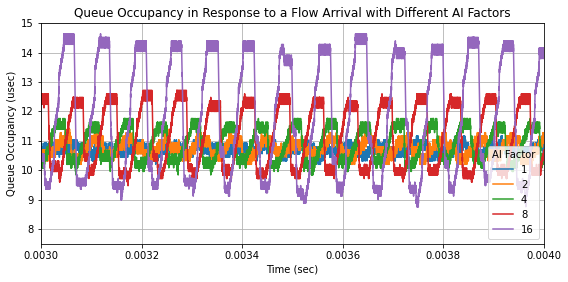

In [20]:
plt.figure(figsize=(8,4))
xlim = [0.003, 0.004]

for ai, data in qlog_data.items():
  plt.plot(data['times'],data['q_sizes'], label=ai)

if xlim is not None:
  plt.xlim(xlim)
plt.ylim([7.5,15])

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Arrival with Different AI Factors')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.legend(title='AI Factor', loc='lower right')
plt.tight_layout()

plt.show()

In [9]:
output_notebook()
p = figure(plot_width=900, plot_height=400)
# print(plt.rcParams['axes.prop_cycle'].by_key()['color'])
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
idx = 0
for ai, data in qlog_data.items():
  p.line(data['times'],data['q_sizes'], 
           legend_label=ai, line_color=colors[idx])
  idx += 1

show(p)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
std_devs = []
for ai in ais:
  q_sizes = qlog_data[str(ai)]['q_sizes']
  q_sizes = q_sizes[len(q_sizes)//2:3*len(q_sizes)//4]
  std_devs.append(statistics.stdev(q_sizes))

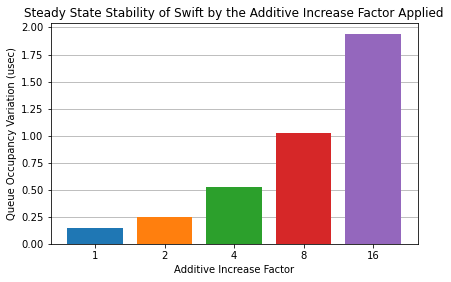

In [21]:
plt.figure()
plt.bar(qlog_data.keys(),std_devs, color=colors)
plt.xlabel('Additive Increase Factor')
plt.ylabel('Queue Occupancy Variation (usec)')
plt.title('Steady State Stability of Swift by the Additive Increase Factor Applied')
plt.gca().set_axisbelow(True)
plt.grid(axis='y')
plt.tight_layout()
plt.show()